# An example of an RV analysis including a GP treatment of stellar activity

The following is an example of how I typically approach modelling an RV time series that is known to contain at least one transiting planet plus stellar activity. The intention is to illustrate the steps that I take to go from the input time series to physical models of planetary signals and a probabilistic model of stellar activity in the form of a 1d Gaussian process. Hopefully you find the instructions herein useful if you are new to RV data analysis.

In this example we'll consider the published data of the two-planet system around the nearby M dwarf K2-18 (https://arxiv.org/abs/1707.04292). 

## Step 1: visualize the RVs and identify significant periodic signals

Let's begin by first reading in the HARPS RV time series and visualizing the data and its generalized Lomb-Scargle periodogram to identify significant periodicities in the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george, emcee, bgls, time, warnings, corner
from scipy.signal import medfilt        # median filter
from scipy.interpolate import interp1d  # 1d interpolation
from scipy.stats import gaussian_kde    # kernel density estimations
from rvcurve import RV as kep_model     # compute Keplerian planet models
from PyAstronomy.pyasl import foldAt    # phase-fold time series
from uncertainties import unumpy as unp # propagating Gaussian uncertainties
%matplotlib inline

In [2]:
# read in HARPs time series
d = np.loadtxt('./input_data/2M1130+0735_05052017_w7s5c5_NAIRA_v1.rdb', skiprows=2)
bjd, rv, erv = d[:,:3].T   # only read in the RV time series and its uncertainties
bjd += 2.4e6   # convert to barycentric julian date
rv *= 1e3      # km/s -> m/s
erv *= 1e3     # km/s -> m/s

First we should inspect the RVs themselves for the sake of transparency.

Text(0,0.5,u'RV [m/s]')

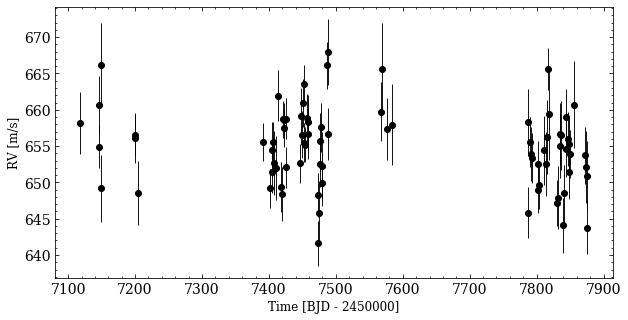

In [3]:
# visualize RVs
global t0
t0 = 245e4
plt.figure(figsize=(10,5))
plt.errorbar(bjd-t0, rv, erv, fmt='ko', elinewidth=.9)
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
plt.ylabel('RV [m/s]', fontsize=12)

So the RVs look reasonable in that there are no obvious outliers. Furthermore, we can see that the star was observed by HARPS over three distinct observing windows each separated by $\sim$ 200 days or $\sim$ 6-7 months.

Next let's plot the Bayesian generalized Lomb-Scargle (BGLS) periodogram (https://arxiv.org/abs/1412.0467) and highlight the periodic signal from the known transiting sub-Neptune K2-18b at $\sim$ 33 days. Since we know that this system hosts a planet whose orbital period is $\sim$ 33 days, we expect a periodic signal to exist in the RVs at that period assuming that the time series contains a sufficient number of measurements (it does) and the expected amplitude of the planetary signal is at least comparable to the typical RV uncertainties.

In [4]:
Pb, T0b = 32.93963, 2456836.1849   # period and mid-transit time of the transiting planet from the K2 light curve
per, pwr = bgls.bgls(bjd, rv, erv, plow=.5, phigh=1e3, n_steps=1e3)

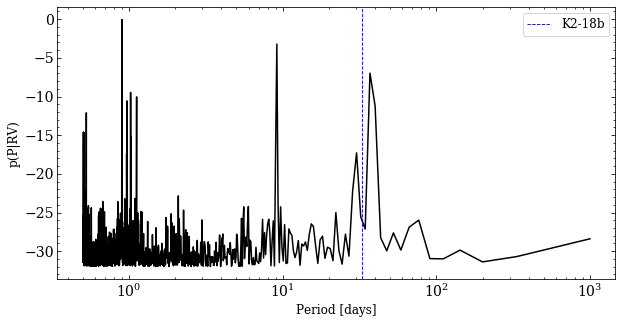

In [5]:
# plot the BGLS
plt.figure(figsize=(10,5))
plt.plot(per, np.log(pwr), 'k-')
plt.axvline(Pb, ls='--', lw=.9, color='b', label='K2-18b')
plt.xscale('log'), plt.xlabel('Period [days]', fontsize=12)
plt.ylabel('p(P|RV)', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

A number of significant peaks can be seen in the BGLS periodogram. The least interesting ones are the aliases close to 1 day and half a day that are always present in RV time series and results from the fact that the instrument is on the ground and is rotating relative to the distant stars with a period of 1 day (the signal at half a day is the first harmonic of 1 day).

The more interesting signals are<br>

1) a strong peak at $\sim$ 9 days which is likely due to a non-transiting planet in this system and<br>
2) a pair of peaks surrounding the transiting planet's orbit period of 33 days.<br>

It turns out that the joint peaks around 33 days may also be attributed to stellar rotation as well as to the RV signal from the known transiting planet. Let's confirm this by considering the star's K2 light curve from which the photometric rotation period can be measured.

## Step 2: visualize the K2 photometry of K2-18

Specifically the cleaned K2 photometry from the EVEREST light curve extraction pipeline (https://archive.stsci.edu/prepds/everest/).

In [6]:
# read in the cleaned K2 photometry from the EVEREST pipeline
bjdK2, flux, eflux = np.load('input_data/k218_k2_photometry.npy').T
bjdK2 += 2454833  # convert the barycentric julian date

In [7]:
# isolate points in and out of transit (in-transit points are identified by eye)
transit_indices = np.append(np.arange(1201,1207), np.arange(2602,2610))
intransit = np.in1d(np.arange(bjdK2.size), transit_indices)
outtransit = np.invert(intransit)

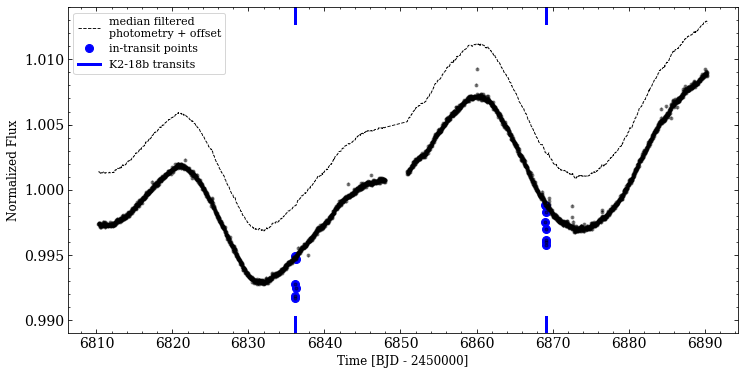

In [8]:
# visualize the light curve and highlight the transits
plt.figure(figsize=(12,6))
plt.errorbar(bjdK2-t0, flux, eflux, fmt='k.', elinewidth=.9, alpha=.4)
plt.plot(bjdK2[outtransit]-t0, medfilt(flux[outtransit],9)+4e-3, 'k--', lw=.9, 
         label='median filtered\nphotometry + offset')
plt.plot(bjdK2[intransit]-t0, flux[intransit], 'bo', ms=8, label='in-transit points')
for i in range(2):
    plt.axvline(T0b+i*Pb-t0, ls='-', lw=3, color='b', ymax=.05, label='K2-18b transits')
    plt.axvline(T0b+i*Pb-t0, ls='-', lw=3, color='b', ymin=.95)
plt.ylim((.989,1.014))
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.legend(loc='upper left', fontsize=11)

The baseline of the K2 photometry only lasts for 80 days. Within that time we can clearly see large-scale photometric variations with a period of $\sim$ 40 days which is due to active regions (e.g. star spots) on the surface of K2-18 rotating in and out of view at the stellar rotation period. Two transits of K2-18b are also observed and are separated by the planet's orbital period of $\sim$ 33 days.

Also depicted is the median filtered photometry, with transits removed, and offset for clarity. This smoothed light curve will be useful when fitting the photometry.

## Step 3: fit the photometry with a quasi-periodic Gaussian process

Gaussian processes are a non-parametric set of model functions that are well-suited to modelling stochastic processes like the stellar activity that gives rise to the photometric variations observed for K2-18. Details of Gaussian processes (GPs) as they pertain to modelling stellar activity can be found in Chapter 2.2 of my thesis (*link pending*).

We will use the $\texttt{george}$ package to construct our GPs and perform the necessary matrix algebra. A description and examples of how to use $\texttt{george}$ can be found here: https://george.readthedocs.io/en/latest/.

Next we define the functions needed to compute the GP model and run an MCMC using the $\texttt{emcee}$ package (https://arxiv.org/abs/1202.3665). Details on how to work with $\texttt{emcee}$ can be found here: http://dfm.io/emcee/current/.

In [9]:
def phot_model(theta, bjd, flux, eflux, bjdpred=[]):
    '''Compute GP model given the input photometry.'''
    # sanity checks
    assert len(theta) == 5                      # need five hyperparameters {lna, lnlambda, lnGamma, lnP, s}
    assert bjd.size == flux.size == eflux.size  # all time series vectors must have the same length
    assert np.all(np.isfinite(bjd+flux+eflux))  # all vector values must be finite (i.e. no NaNs or infs)
    
    # warning message
    if bjd.size >= 1e3: 
        message = '\nLarge time series are expensive to model with Gaussian processes. The input data contains ' + \
        '%i measurements. Consider binning the input data first.'%(bjd.size)
        warnings.warn(message)
    
    # define the GP prior
    agp, lgp, Ggp, Pgp, s = np.exp(theta)
    k_sqexp = george.kernels.ExpSquaredKernel(lgp)    # squared exponential kernel
    k_per = george.kernels.ExpSine2Kernel(Ggp, Pgp)   # periodic kernel
    gp = george.GP(agp * k_sqexp * k_per)             # quasi-periodic kernel
    
    # compute the covariance matrix
    try:
        gp.compute(bjd, np.sqrt(eflux**2 + s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    
    # compute the mean and standard deviation of the GP posterior
    bjdpred = bjdpred if len(bjdpred) > 0 else bjd
    mu, cov = gp.predict(flux, bjdpred)
    sig = np.sqrt(np.diag(cov))
    
    return gp, bjdpred, mu, sig

In [10]:
def lnlike_K2(theta, bjd, flux, eflux):
    '''Compute the ln likelihood of the K2 photometry modelled with a quasi-periodic GP regression model.'''
    gp,_,_,_ = phot_model(theta, bjd, flux, eflux)
    return gp.lnlikelihood(flux, quiet=True)

In [11]:
def lnprior_K2(theta):
    '''Compute the prior on the GP hyperparameters. This function assumes that the priors are uniform in log space 
    for all parameters.'''
    # sanity check
    assert len(theta) == 5
    
    # compute the prior for each hyperparameter
    lnagp, lnlgp, lnGgp, lnPgp, lns = theta
    lnpriors = np.zeros(5)
    lnpriors[0] = lnuniform(lnagp, -20, 0)
    lnpriors[1] = lnuniform(lnlgp, 0, 10)
    lnpriors[2] = lnuniform(lnGgp, -5, 5)
    lnpriors[3] = lnuniform(lnPgp, np.log(30), np.log(50))   # narrow this prior because we want to focus on Prot
    lnpriors[4] = lnuniform(lns, -20, 0)
    
    # return the prior
    return np.sum(lnpriors)

    
    
def lnuniform(val, min_val, max_val):
    '''Define the uniform prior and return the log of its value.'''
    assert max_val > min_val
    return np.log(1./(max_val-min_val)) if min_val <= val <= max_val else -np.inf

In [12]:
def lnprob_K2(theta, bjd, flux, eflux):
    '''Compute the unnormalized posterior from the likelihood and the prior.'''
    lnp = lnprior_K2(theta)
    return lnp + lnlike_K2(theta, bjd, flux, eflux) if np.isfinite(lnp) else -np.inf

In [13]:
def run_emcee_K2(theta, bjd, flux, eflux, initialize, nwalkers=100, burnin=200, nsteps=200):
    '''Run an MCMC on the input K2 light curve modelled with a quasi-periodic Gaussian process.'''
    # Initialize walkers in the model parameter space
    assert len(theta) == len(initialize)
    ndim = len(theta)
    p0 = []
    for i in range(nwalkers):
        p0.append(theta + initialize*np.random.randn(ndim))

    # Initialize the emcee sampler
    args = (bjd, flux, eflux)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_K2, args=args, a=1.9)

    # Run the burn-in phase
    # I like to time this phase and report the acceptance fraction to gauge how successful the model is
    # The acceptance fraction should be between ~ 20-50%
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burn-in mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burn-in took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()

    # Run the full MCMC after burn-in
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print 'Mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes\n'%((time.time()-t0)/60.)

    # Return the sampler object (often not needed) and the sampler chains
    samples = sampler.chain.reshape((-1, ndim))
    return sampler, samples

Let us resample the K2-18 light curve by first ignoring the in-transit points (because they are not a stellar activity effect) and also by reducing the observing cadence to reduce the computation time of the MCMC. Note that although it turns out not to be important in this example, temporal binning can be dangerous as it removes short timescale variations that may be relevant to our stellar activity model.

In [14]:
# resample the K2 photometry
fint = interp1d(bjdK2[outtransit], medfilt(flux[outtransit]))
bjdK2_resamp = bjdK2[np.arange(0,bjdK2.size,10)]
flux_resamp = fint(bjdK2_resamp)
eflux_resamp = np.repeat(1e-4, bjdK2_resamp.size)   # arbitrary value set by the short-term scatter in the photometry

Next we provide initial guesses of the GP hyperparameters and run the MCMC to fit the K2-18 light curve with a quasi-periodic GP.

In [15]:
# run the MCMC on the training photometry
theta_guess = np.log(1e-3), np.log(80), np.log(1), np.log(40), np.log(1e-6)
initialize = np.repeat(.2, len(theta_guess))
sampler, samples = run_emcee_K2(theta_guess, bjdK2_resamp, flux_resamp, eflux_resamp, initialize)

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Burn-in mean acceptance fraction is 0.4363
Burn-in took 6.6291 minutes

Mean acceptance fraction is 0.4463
Full MCMC took 12.4059 minutes



## Step 4: save and visualize the training results

In [16]:
# save the samples of the covariance hyperparameters
# saved data can be loaded using np.load
np.save('output_data/training_posteriors', samples)

Next we plot the joint and marginalized posterior distributions of the GP hyperparameters. The posteriors of parameters $\{ \ln{\lambda}, \ln{\Gamma}, \ln{P} \}$ represent the covariance properties of the temporally correlated stellar activity signal and will therefore be used to inform our stellar activity model in the RVs.

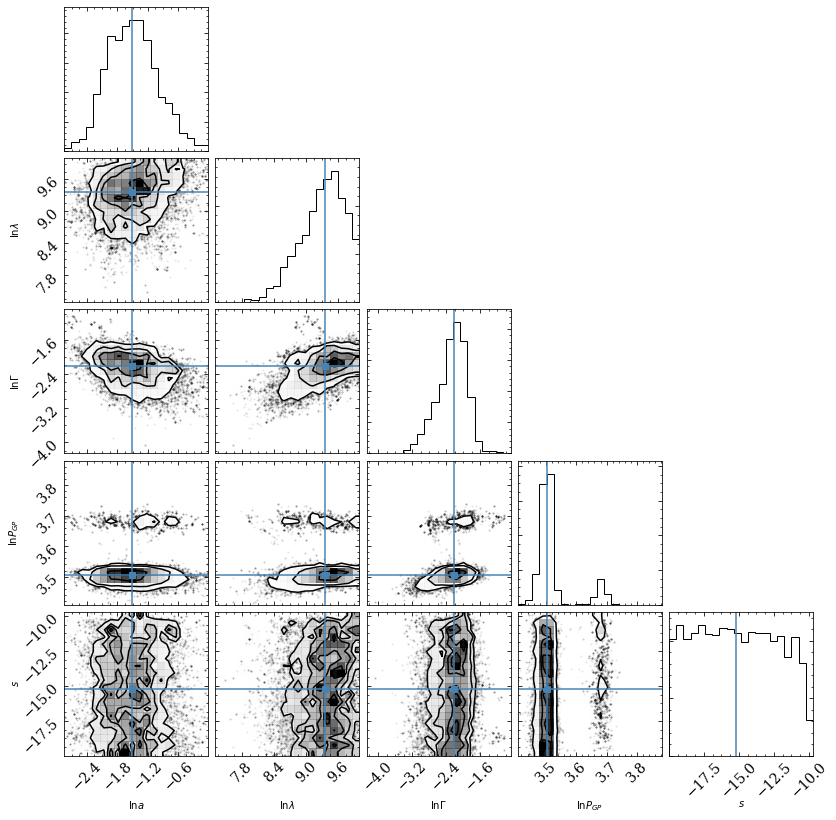

In [17]:
# plot the joint and marginalized posteriors of the GP hyperparameters
theta_results = np.median(samples, axis=0)
labels = ['$\ln{a}$', '$\ln{\lambda}$', '$\ln{\Gamma}$', '$\ln{P_{GP}}$', '$s$']
_=corner.corner(samples, bins=20, truths=theta_results, labels=labels)

We can also visualize the resampled light curve along with the mean and standard deviation of our GP posterior distribution to ensure that we have obtained a reasonable solution.

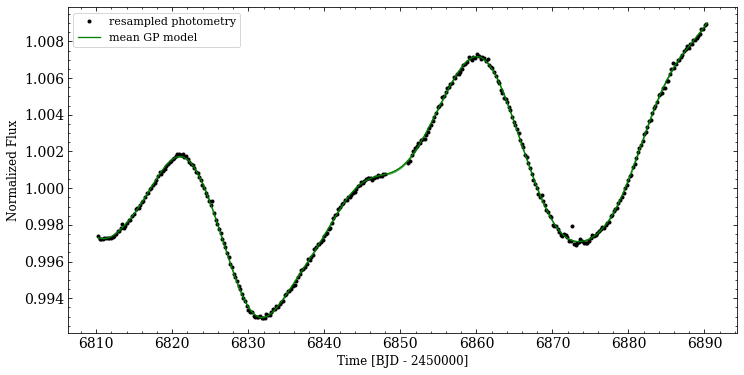

In [18]:
# visualize the light curve and the GP model
_, bjdpred, mu, sig = phot_model(theta_results, bjdK2_resamp, flux_resamp, eflux_resamp, 
                                 np.linspace(bjdK2.min(), bjdK2.max(), 1000))

plt.figure(figsize=(12,6))
plt.plot(bjdK2_resamp-t0, flux_resamp, 'k.', label='resampled photometry')
plt.fill_between(bjdpred-t0, mu-sig, mu+sig, color='g', alpha=.5)
plt.plot(bjdpred-t0, mu, 'g-', lw=1.3, label='mean GP model')
plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)
plt.legend(loc='upper left', fontsize=11)

Looks good.

## Step 5: begin the RV analysis

Now that our GP model has learned the covariance properties of the stellar activity signal from the K2 photometry, we can proceed with modelling the HARPS RVs with planets plus stellar activity. 

First let's recall the BGLS of the RVs and identify all significant signals that we want to include in our full RV model. Note that in a real analysis this model can and should be modified by considering, for example, different numbers of assumed planets, alternative GP training sets, etc. By considering alternative RV models we relax certain assumptions about the signals in our data and by comparing the results from competing model we can (hopefully) confirm the robustness of our results.

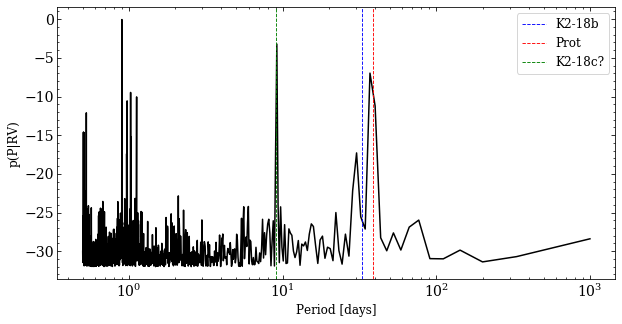

In [19]:
# periods of interest from the transiting planet, stellar rotation, and the additional signal at 9 days
Ps = [32.93963, 38.6, 9]
Plabels = ['K2-18b','Prot','K2-18c?']

# plot the BGLS
per, pwr = bgls.bgls(bjd, rv, erv, plow=.5, phigh=1e3, n_steps=1e3)
plt.figure(figsize=(10,5))
plt.plot(per, np.log(pwr), 'k-')
for i,p in enumerate(Ps):
    plt.axvline(p, ls='--', lw=.9, color=['b','r','g'][i], label=Plabels[i])
plt.xscale('log'), plt.xlabel('Period [days]', fontsize=12)
plt.ylabel('p(P|RV)', fontsize=12)
plt.legend(loc='upper right', fontsize=12)

Recall that the peaks around $\sim$ 33 days can be attributed to stellar rotation and the transiting planet K2-18b. Furthermore, the signal at $\sim$ 9 days is only seen in the BGLS of the RVs and not in the BGLS of any spectroscopic activity indicators or in its window function (not shown here). In this example we will proceed with assuming that there is a second planet in this system with an orbital period of $\sim$ 9 days called K2-18c. A complete discussion of the nature of this signal can be found in https://arxiv.org/abs/1810.04731.

## Step 6: fit the RVs with a two-planet + a trained GP model

Here we define all of the functions needed to compute the full RV model and run an MCMC again using the $\texttt{emcee}$ package.

In [20]:
def full_RV_model(theta, bjd, rv, erv, bjdpred=[]):
    '''Compute the RV model including a GP activity model plus 2 Keplerian planet solutions.'''
    # sanity checks
    assert len(theta) == 16 # need 16 model parameters {lna,lnlambda,lnGamma,lnP,s,V0,Pb,T0b,Kb,hb,kb,Pc,T0c,Kc,hc,hc}
    assert bjd.size == rv.size == erv.size   # all time series vectors must have the same length
    assert np.all(np.isfinite(bjd+rv+erv))   # all vector values must be finite (i.e. no NaNs or infs)
    
    # define the GP prior
    agp, lgp, Ggp, Pgp = np.exp(theta[:4])
    k_sqexp = george.kernels.ExpSquaredKernel(lgp)    # squared exponential kernel
    k_per = george.kernels.ExpSine2Kernel(Ggp, Pgp)   # periodic kernel
    gp = george.GP(agp * k_sqexp * k_per)             # quasi-periodic kernel
    
    # compute the covariance matrix
    try:
        s = theta[4]
        gp.compute(bjd, np.sqrt(erv**2 + s**2))
    except (ValueError, np.linalg.LinAlgError):
        return -np.inf
    
    # compute the planet models
    Pb, T0b, Kb, hb, kb = theta[6:11]
    _,kepb = kep_model(bjd, (Pb,T0b,0,Kb,hb,kb))
    Pc, T0c, Kc, hc, kc = theta[11:]
    _,kepc = kep_model(bjd, (Pc,T0c,0,Kc,hc,kc))

    # compute the mean and standard deviation of the GP posterior
    V0 = theta[5]
    bjdpred = bjdpred if len(bjdpred) > 0 else bjd
    mu, cov = gp.predict(rv-V0-kepb-kepc, bjdpred)
    sig = np.sqrt(np.diag(cov))
    
    # recompute Keplerians at the new sampling
    _,kepb = kep_model(bjdpred, (Pb,T0b,0,Kb,hb,kb))
    _,kepc = kep_model(bjdpred, (Pc,T0c,0,Kc,hc,kc))
    
    return gp, bjdpred, mu, sig, V0, kepb, kepc

In [21]:
def lnlike_RV(theta, bjd, rv, erv):
    '''Compute the ln likelihood of the RVs modelled with a quasi-periodic GP regression model plus two planets.'''
    gp,_,_,_,V0,kepb,kepc = full_RV_model(theta, bjd, rv, erv)
    return gp.lnlikelihood(rv-V0-kepb-kepc, quiet=True)

In [22]:
def lnprior_RV(theta, int_l, int_G, int_P):
    '''Compute the prior on the RV model parameters. To adopt an alternate prior on any model parameter will 
    require modification of this function.'''
    # sanity check
    assert len(theta) == 16
    
    # compute the prior for each parameter
    lnagp,lnlgp,lnGgp,lnPgp,s,V0,Pb,T0b,Kb,hb,kb,Pc,T0c,Kc,hc,kc = theta
    lnpriors = np.zeros(16)
    lnpriors[0] = lnuniform(lnagp, -4, 4)
    lnpriors[1] = lncustom_int(lnlgp, int_l)
    lnpriors[2] = lncustom_int(lnGgp, int_G)
    lnpriors[3] = lncustom_int(lnPgp, int_P)
    
    lnpriors[4] = lnjeffreysprior(s, 1e-2, 10)
    lnpriors[5] = lnuniform(V0, 650, 660)
    
    lnpriors[6] = lngaussian(Pb, 32.93963, 1e-4)
    lnpriors[7] = lngaussian(T0b, 2457264.3916, 6e-4)
    lnpriors[8] = lnjeffreysprior(Kb, 1, 10)
    eb,_ = hk2ew(hb, kb)
    lnpriors[9] = lnuniform(hb, -1, 1) if eb < 1 else -np.inf
    lnpriors[10] = lnuniform(kb, -1, 1) if eb < 1 else -np.inf

    lnpriors[11] = lnuniform(Pc, 6, 12)
    lnpriors[12] = lnuniform(T0c, 2457260, 2457272)
    lnpriors[13] = lnjeffreysprior(Kc, 1, 10)
    ec,_ = hk2ew(hc, kc)
    lnpriors[14] = lnuniform(hc, -1, 1) if ec < 1 else -np.inf
    lnpriors[15] = lnuniform(kc, -1, 1) if ec < 1 else -np.inf
    
    # return the prior
    return np.sum(lnpriors)



def lncustom_int(val, fint):
    '''Compute the custom log prior given an input interpolator function over the parameter probability 
    from training.'''
    try:
        return np.log(fint(val))
    except ValueError:
        return -np.inf
    
    
def lngaussian(val, mean, std):
    '''Define the Gaussian prior distribution and return the log of its value.'''
    return -.5*(((val-mean)/std)**2 + np.log(2*np.pi)) - np.log(std)
    

def lnjeffreysprior(val, min_val, max_val):
    '''Jeffreys prior from Gregory 2005 (see Eq 17). http://adsabs.harvard.edu/abs/2005ApJ...631.1198G.
    Return the log of its value.'''
    assert max_val > min_val
    try:
        return np.log(1./(val * np.log(max_val/min_val)))
    except ValueError:
        return -np.inf


def hk2ew(h, k):
    '''Convert the parameters h and k to an eccentricity and argument of periastron.'''
    ecc = h*h + k*k
    omega = np.arctan2(k, h)
    return ecc, omega

In [23]:
def lnprob_RV(theta, bjd, rv, erv, int_l, int_G, int_P):
    '''Compute the unnormalized posterior from the likelihood and prior.'''
    lnp = lnprior_RV(theta, int_l, int_G, int_P)
    return lnp + lnlike_RV(theta, bjd, rv, erv) if np.isfinite(lnp) else -np.inf

In [24]:
def run_emcee_RV(theta, bjd, flux, eflux, initialize, samplesGP, nwalkers=100, burnin=200, nsteps=200):
    '''Run an MCMC on the input RV time series modelled with a trained quasi-periodic Gaussian process 
    and two planets.'''
    # Initialize walkers in the model parameter space
    assert len(theta) == len(initialize)
    ndim = len(theta)
    p0 = []
    for i in range(nwalkers):
        p0.append(theta + initialize*np.random.randn(ndim))

    # construct interpolators for the trained GP hyperparameters
    int_l, int_G, int_P = construct_interpolators_lGP(samplesGP)
        
    # Initialize the emcee sampler
    args = (bjd, rv, erv, int_l, int_G, int_P)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_RV, args=args, a=1.9)

    # Run the burn-in phase
    # I like to time this phase and report the acceptance fraction to gauge how successful the model is
    t0 = time.time()
    p0,_,_ = sampler.run_mcmc(p0, burnin)
    print 'Burn-in mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Burn-in took %.4f minutes\n'%((time.time()-t0)/60.)
    sampler.reset()

    # Run the full MCMC after burn-in
    p0,_,_ = sampler.run_mcmc(p0, nsteps)
    print 'Mean acceptance fraction is %.4f'%np.mean(sampler.acceptance_fraction)
    print 'Full MCMC took %.4f minutes\n'%((time.time()-t0)/60.)

    # Return the sampler object (often not needed) and the sampler chains
    samples = sampler.chain.reshape((-1, ndim))
    return sampler, samples

Because the GP hyperparameters in our RV model are informed by their posteriors from training on the K2 photometry, the priors on those parameters need to be interpolated from their respective training posteriors. Note that this process assumes that the three hyperparameters are uncorrelated. 

In [25]:
def construct_interpolators_lGP(samplesGP):
    '''Given the marginalized posteriors of the GP hyperparameters, construct probability interpolators.'''
    assert samplesGP.shape[1] == 3
    
    # get parameter ranges
    mins, maxs = np.nanmin(samplesGP, axis=0), np.nanmax(samplesGP, axis=0)
    lnlarr = np.linspace(mins[0], maxs[0], 100)
    lnGarr = np.linspace(mins[1], maxs[1], 100)
    lnParr = np.linspace(mins[2], maxs[2], 100)
    
    # compute the kernel density estimations
    KDE_l = gaussian_kde(samplesGP[:,0]).pdf(lnlarr)
    KDE_G = gaussian_kde(samplesGP[:,1]).pdf(lnGarr)
    KDE_P = gaussian_kde(samplesGP[:,2]).pdf(lnParr)
    
    # construct interpolators
    int_l = interp1d(lnlarr, KDE_l)
    int_G = interp1d(lnGarr, KDE_G)
    int_P = interp1d(lnParr, KDE_P)
    
    return int_l, int_G, int_P

Let's initialize the model parameters and run the MCMC on the RV time series.

In [26]:
# get GP hyperparameter posteriors from training
# only want the hyperparameters {lnl, lnG, lnP} because the other hyperparameters are in units of the training set
samplesGP = np.load('output_data/training_posteriors.npy')[:,1:4]

# initialize the model parameters
theta_guess = np.append(np.log(2), np.median(samplesGP, axis=0))
theta_guess = np.append(theta_guess, [1e-1, rv.mean()])
theta_guess = np.append(theta_guess, [32.93963, 2457264.39157, 3, 0, 0])
theta_guess = np.append(theta_guess, [9, 2457264, 4, 0, 0])

# setup the walker initializations
initialize = np.repeat(.2, 4)
initialize = np.append(initialize, [1e-2, 1e-1])
initialize = np.append(initialize, [1e-5, 1e-4, 1e-1, 1e-1, 1e-1])
initialize = np.append(initialize, [1, 1, 1e-1, 1e-1, 1e-1])

# run the MCMC
sampler, samples = run_emcee_RV(theta_guess, bjd, rv, erv, initialize, samplesGP)

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in log


Burn-in mean acceptance fraction is 0.1027
Burn-in took 4.9026 minutes

Mean acceptance fraction is 0.1035
Full MCMC took 9.7394 minutes



## Step 7: save and visualize the results of our RV analysis

In [27]:
# save the samples of the RV model parameters
np.save('output_data/RV_posteriors', samples)

Get the parameter values, and their uncertainties, and plot the joint and marginalized posterior distributions of the RV model parameters.

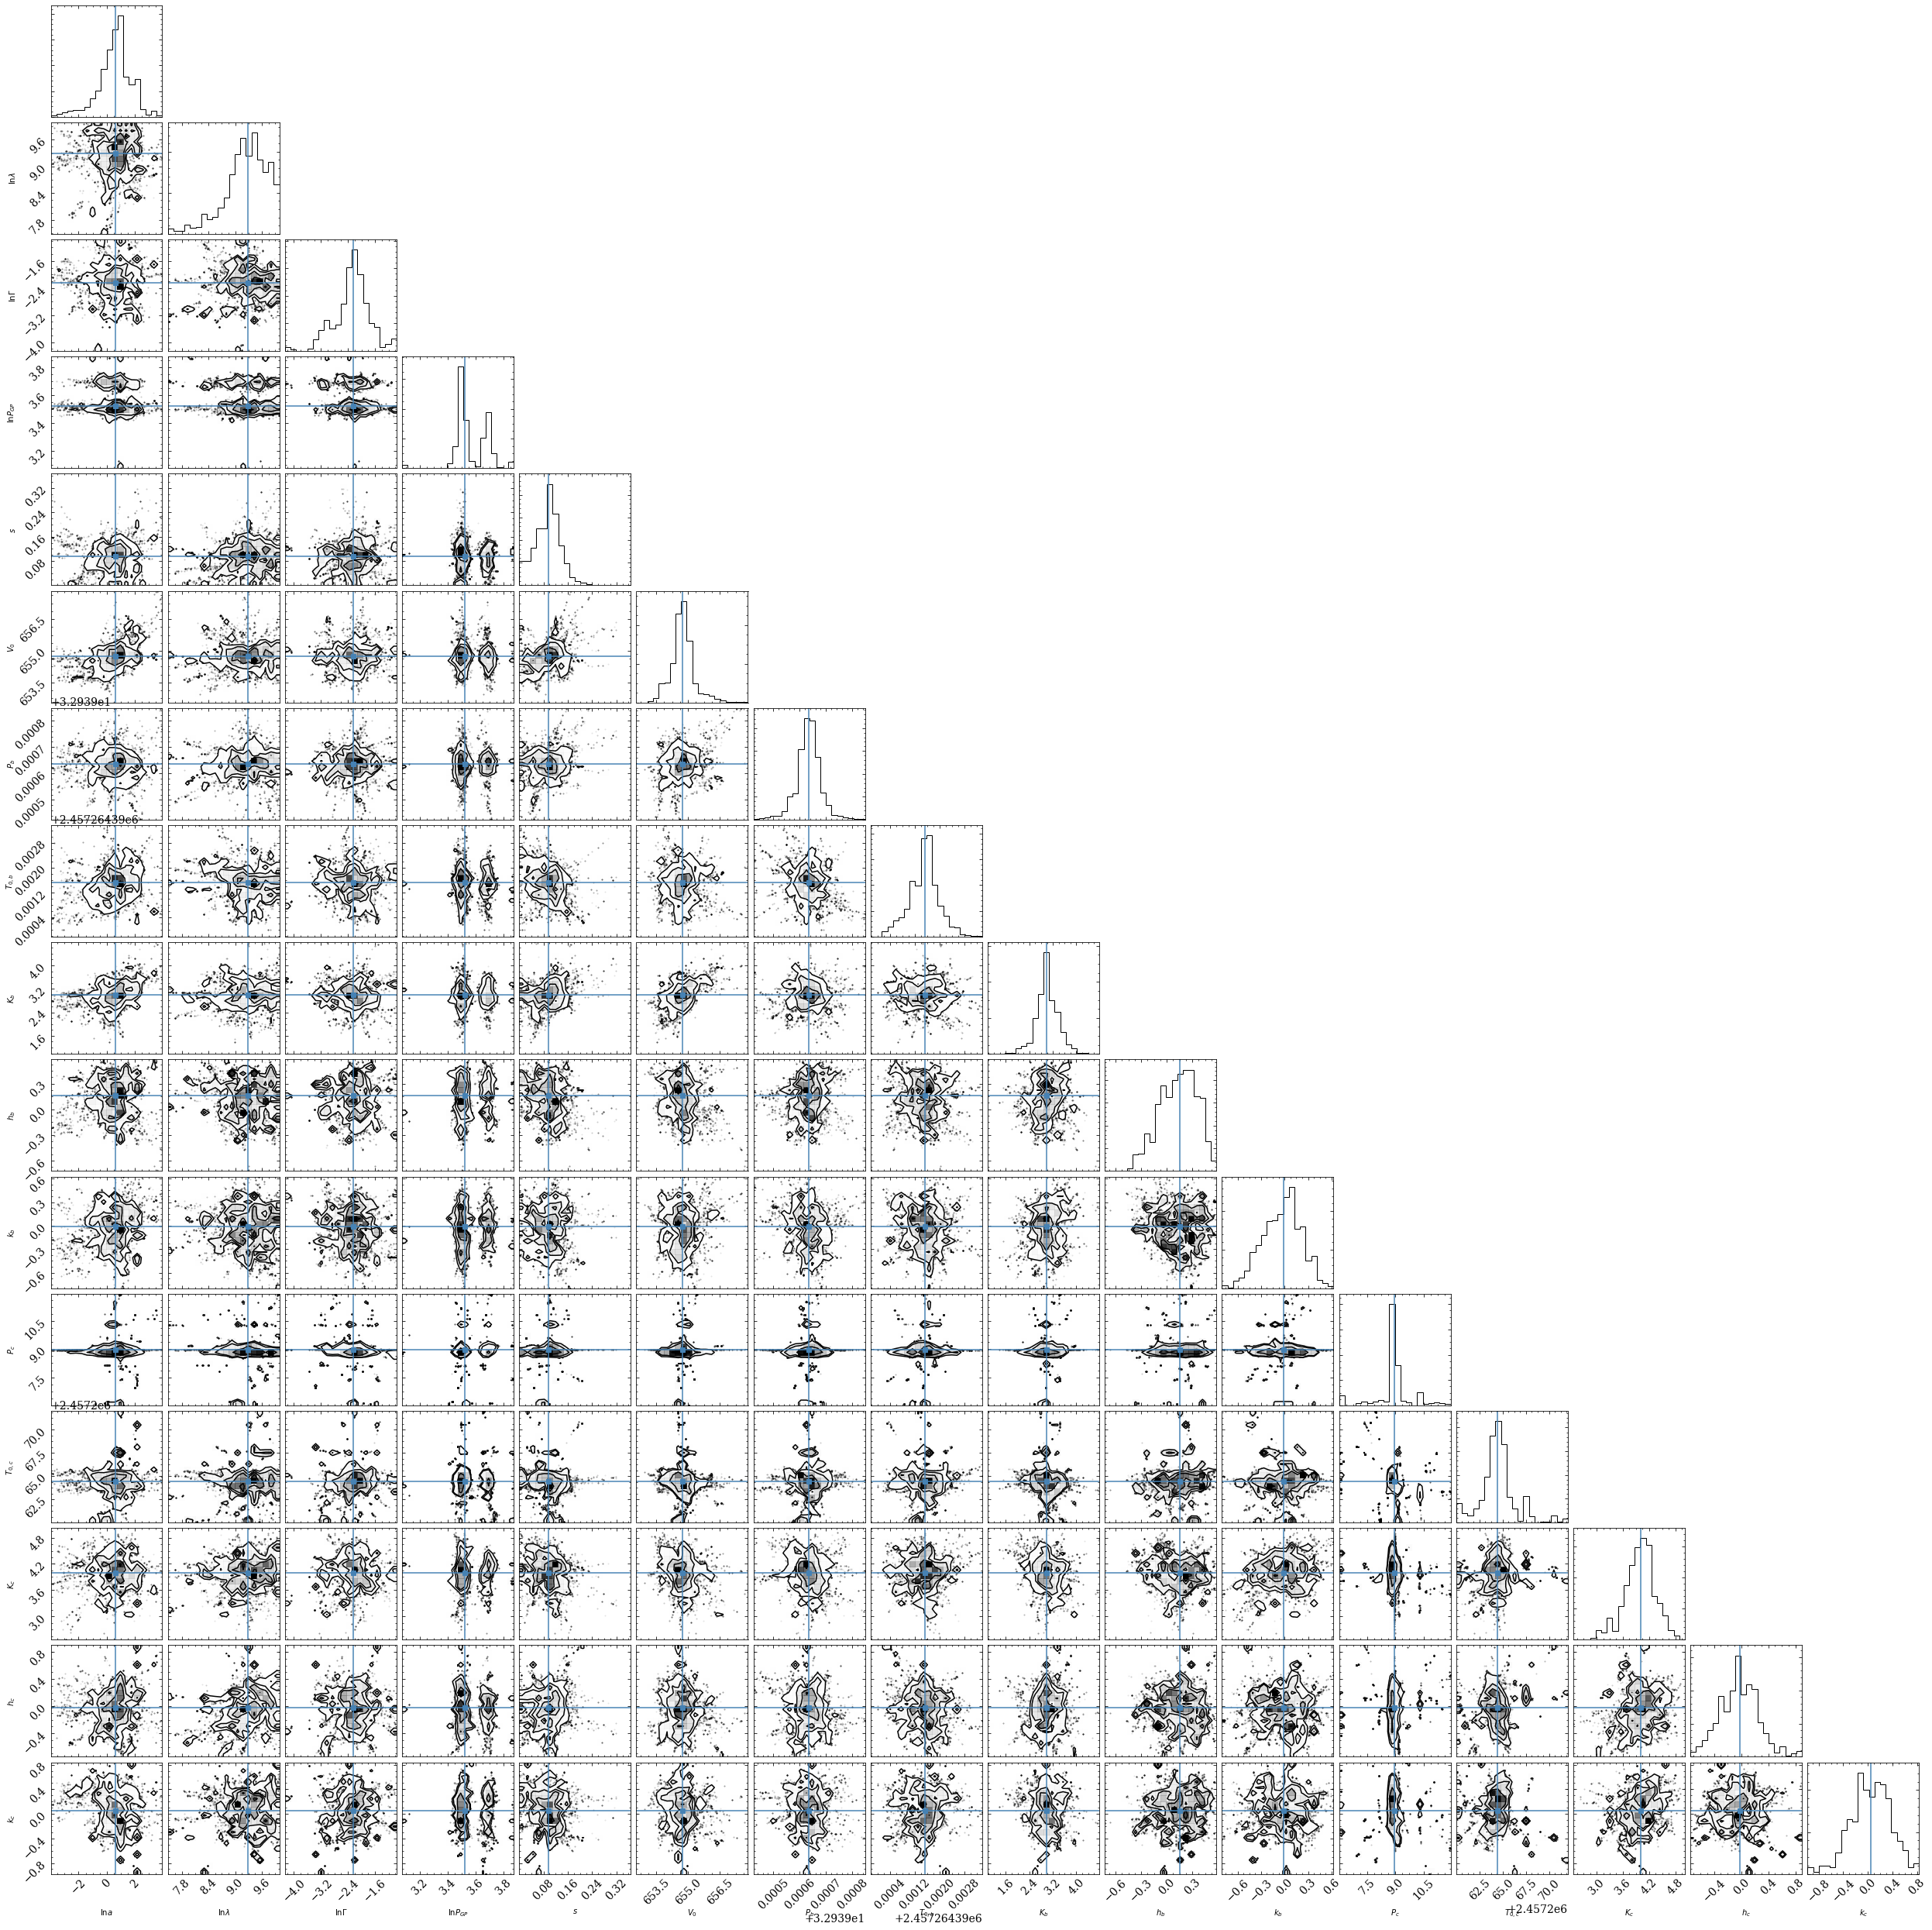

In [28]:
# plot the joint and marginalized posteriors of the GP hyperparameters
theta_16th, theta_results, theta_84th = np.percentile(samples, (16,50,84), axis=0)
ehi_theta = theta_84th - theta_results
elo_theta = theta_results - theta_16th
labels = ['$\ln{a}$','$\ln{\lambda}$','$\ln{\Gamma}$','$\ln{P_{GP}}$','$s$','$V_0$',
         '$P_b$','$T_{0,b}$','$K_b$','$h_b$','$k_b$',
         '$P_c$','$T_{0,c}$','$K_c$','$h_c$','$k_c$']
units = ['','','','\n','m/s','m/s\n','days','BJD','m/s','','\n','days','BJD','m/s','','']
_=corner.corner(samples, bins=20, truths=theta_results, labels=labels)

The joint and marginalized parameter posteriors depict each parameter's maximum a-posteriori (MAP) value and its uncertainty. Each parameter's uncertainty is often taken from the 16th and 84th percentile of its marginalized posterior. Note however that here we have taken the parameter values to be the median values of their repsective posteriors rather than the MAP values. It is up to the user to decide exactly what point estimates should be used to describe each parameter.

The median parameter values and their uncertainties from this analysis are

In [29]:
# print parameter point estimates
for i in range(theta_results.size):
    print r'%s = %.4f + %.4f - %.4f %s'%(labels[i].replace('$',''),theta_results[i],ehi_theta[i],elo_theta[i],units[i])

\ln{a} = 0.6479 + 0.9711 - 1.0542 
\ln{\lambda} = 9.2890 + 0.4292 - 0.4907 
\ln{\Gamma} = -2.2556 + 0.4135 - 0.5688 
\ln{P_{GP}} = 3.5228 + 0.1703 - 0.0373 

s = 0.0958 + 0.0353 - 0.0465 m/s
V_0 = 654.7256 + 0.3785 - 0.4538 m/s

P_b = 32.9396 + 0.0000 - 0.0000 days
T_{0,b} = 2457264.3915 + 0.0004 - 0.0005 BJD
K_b = 2.9834 + 0.4197 - 0.3175 m/s
h_b = 0.1570 + 0.1963 - 0.2609 
k_b = -0.0098 + 0.2213 - 0.2755 

P_c = 8.9625 + 0.2602 - 0.1820 days
T_{0,c} = 2457264.4061 + 1.1249 - 1.2520 BJD
K_c = 4.0029 + 0.3049 - 0.3326 m/s
h_c = -0.0244 + 0.2378 - 0.2946 
k_c = 0.0553 + 0.3053 - 0.3389 


Next we compute the RV models for each of the individual RV model components (i.e. activity, K2-18b, K2-18c) using the median parameter values. We consider both the native HARPS sampling as well as a custom uniform sampling for plotting purposes. Then each RV component is visualized along with its respective BGLS.

In [30]:
# compute the models with the input sampling and a finer sampling for visualization
_,_,mu,sig,V0,kepb,kepc = full_RV_model(theta_results, bjd, rv, erv)
_,bjdpred,mupred,sigpred,_,kepbpred,kepcpred = full_RV_model(theta_results, bjd, rv, erv, 
                                                             np.linspace(bjd.min(), bjd.max(), 1000))

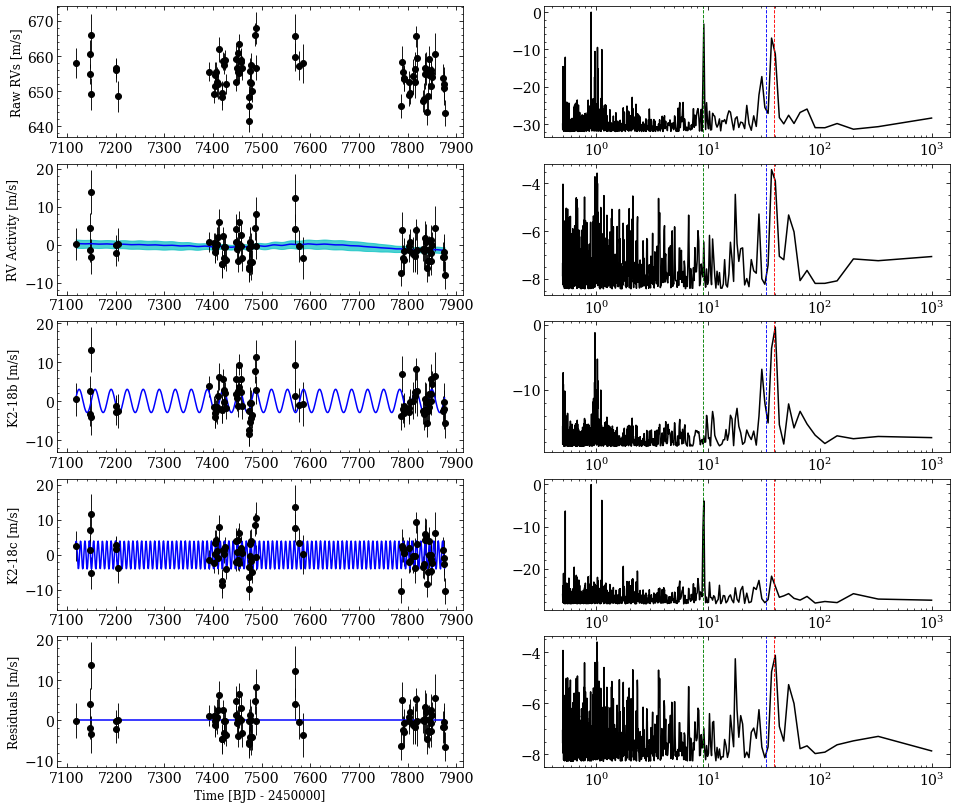

In [31]:
# plot each RV component and its BGLS
RVcomponents = [rv, rv-V0-kepb-kepc, rv-V0-mu-kepc, rv-V0-mu-kepb, rv-V0-mu-kepb-kepc]
RVmodels = [None, mupred, kepbpred, kepcpred, np.zeros(bjdpred.size)]
RVlabels = ['Raw RVs [m/s]', 'RV Activity [m/s]', 'K2-18b [m/s]', 'K2-18c [m/s]', 'Residuals [m/s]']

plt.figure(figsize=(16,14))
ind = 0
for i in range(5):
    
    # plot time series and model
    plt.subplot(5,2,ind+1+2*i)
    plt.errorbar(bjd-t0, RVcomponents[i], erv, fmt='ko', elinewidth=.9)
    if i == 1: plt.fill_between(bjdpred-t0, mupred-sigpred, mupred+sigpred, color='c', alpha=.7)
    if i > 0: plt.plot(bjdpred-t0, RVmodels[i], '-')
    if i == 4: plt.xlabel('Time [BJD - %i]'%t0, fontsize=12)
    plt.ylabel(RVlabels[i], fontsize=12)

    # plot BGLS
    per, pwr = bgls.bgls(bjd, RVcomponents[i], erv, plow=.5, phigh=1e3, n_steps=1e3)
    plt.subplot(5,2,ind+2*(1+i))
    plt.plot(per, np.log(pwr), 'k-')
    for i,p in enumerate(Ps):
        plt.axvline(p, ls='--', lw=.9, color=['b','r','g'][i], label=Plabels[i])
    plt.xscale('log')
    if i == 4: plt.xlabel('Period [days]', fontsize=12)

This plot depicts the raw RVs, the RV stellar activity component, each of the Keplerian planet models, and the RV residuals along with their BGLSs.

1) The raw RVs look identifical to the initial visualizations we created when we first read-in the data.<br>

2) The stellar activity signal appears to have a relatively low amplitude of a few m/s but with a distinct periodicity of $\sim$ 40 days. The most significant peak in its BGLS is close to 40 days but still exhibits the forest of peaks around that period due to aliasing with the window function.<br>

3) K2-18b has a measured semi-amplitude of 3.1 m/s and exhibits the same forest of peaks in its BGLS due to the promximity of its orbital period of $\sim$ 33 days to the stellar rotation period of $\sim$ 40 days.<br>

4) K2-18c has a measured semi-amplitude of 3.0 m/s and is clearly the most significant periodic signal in its BGLS indicating that our GP activity model did not absorb much (if any) of that periodic signal.

5) The RV residuals are dominated by noise indicating that we have done a satisfactory job of modelling all significant periodic signals in the RV data.

Lastly, we phase-fold the activity-corrected data to the orbital periods of the planets to visualize their RV phase curves.

In [32]:
# phase-fold to the planets' orbital periods
Pb, T0b = theta_results[6:8]
Pc, T0c = theta_results[11:13]
phaseb = foldAt(bjd, Pb, T0b)
phasec = foldAt(bjd, Pc, T0c)
phaseb[phaseb >= .5] -= 1   # shift from the [0,1] domain to [-.5,.5] for clarity
phasec[phasec >= .5] -= 1
sb = np.argsort(phaseb)
sc = np.argsort(phasec)

Text(0.5,0,u'Orbital Phase (P=8.963 days)')

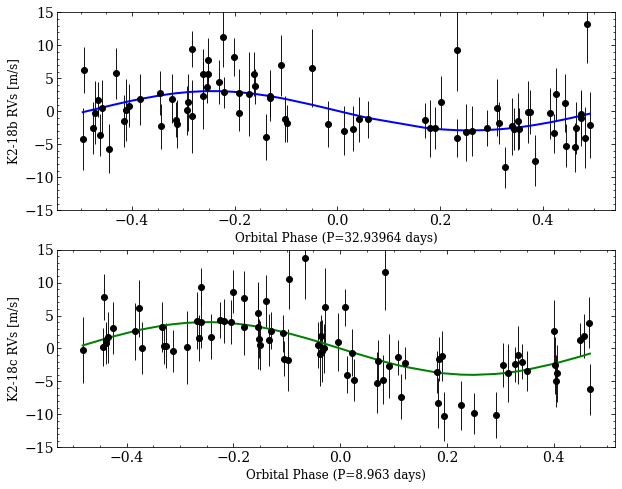

In [33]:
# plot phase-folded RVs
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.errorbar(phaseb, rv-V0-mu-kepc, erv, fmt='ko', elinewidth=.9)
plt.plot(phaseb[sb], kepb[sb], 'b-', lw=2)
plt.ylim((-15,15))
plt.ylabel('K2-18b RVs [m/s]', fontsize=12)
plt.xlabel('Orbital Phase (P=%.5f days)'%Pb, fontsize=12)

plt.subplot(212)
plt.errorbar(phasec, rv-V0-mu-kepb, erv, fmt='ko', elinewidth=.9)
plt.plot(phasec[sc], kepc[sc], 'g-', lw=2)
plt.ylim((-15,15))
plt.ylabel('K2-18c RVs [m/s]', fontsize=12)
plt.xlabel('Orbital Phase (P=%.3f days)'%Pc, fontsize=12)

## Step 8: derive physical planet parameters of interest

Now that we have measured the planet parameters from our RV analysis, we can derive some planet parameters of interest given our knowledge of the star.

In [34]:
def compute_planetmass(P_days, Ms_MSun, K_ms):
    '''Compute the planet mass (in Earth masses) assuming the planet's orbit is circular and oriented edge-on.'''
    K_Earth_ms = 0.0894590658
    return (K_ms/K_Earth_ms) * Ms_MSun**(2./3) * (P_days/365.)**(1./3)

def compute_bulkdensity(mp_MEarth, rp_REarth):
    '''Compute the planet's bulk density.'''
    return 5.55 * mp_MEarth / rp_REarth**3

def compute_sma(P_days, Ms_MSun):
    '''Compute the planet's semimajor axis.'''
    return (P_days/365.)**(2./3) * Ms_MSun**(1./3)

def compute_Teq(sma_AU, Teff_K, Rs_RSun, A=0.3):
    '''Compute the planet's equilibrium temperature.'''
    return 254.8 * ((1.-A)/.7)**(1./4) * (Teff_K/5777.) * (Rs_RSun/sma_AU)**(1./2)

In [35]:
# define known parameters and uncertainties
Ms = unp.uarray(.495, .004)    # K2-18 mass [Solar masses]
Rs = unp.uarray(.469, .010)    # K2-18 radius [Solar radii]
Teff = unp.uarray(3503, 60)    # K2-18 effective temperature [K]
rpb = unp.uarray(2.711, .065)  # K2-18b radius [Earth radii]

# define measured parameters and uncertainties
Pb = unp.uarray(theta_results[6], np.mean([ehi_theta[6], elo_theta[6]]))  # measured orbital period
Kb = unp.uarray(theta_results[8], np.mean([ehi_theta[8], elo_theta[8]]))  # measured semi-amplitude
Pc = unp.uarray(theta_results[11], np.mean([ehi_theta[11], elo_theta[11]]))  # measured orbital period
Kc = unp.uarray(theta_results[13], np.mean([ehi_theta[13], elo_theta[13]]))  # measured semi-amplitude

In [36]:
# derive planetary parameters of interest
mpb, mpc = compute_planetmass(Pb, Ms, Kb), compute_planetmass(Pc, Ms, Kc)
rhob = compute_bulkdensity(mpb, rpb)
smab, smac = compute_sma(Pb, Ms), compute_sma(Pc, Ms)
Teqb, Teqc = compute_Teq(smab, Teff, Rs), compute_Teq(smac, Teff, Rs)
params = [mpb, mpc, rhob, smab, smac, Teqb, Teqc]
labels = ['m_{p,b}','m_{p,c}','rho_{p,b}','a_{p,b}','a_{p,c}','T_{eq,b}','T_{eq,c}']
units = ['Earth masses','Earth masses\n','g/cm^3\n','AU','AU\n','K','K']

for i in range(len(params)):
    print r'%s = %.4f +- %.4f %s'%(labels[i], unp.nominal_values(params[i]), unp.std_devs(params[i]), units[i])

m_{p,b} = 9.3607 +- 1.1575 Earth masses
m_{p,c} = 8.1384 +- 0.6529 Earth masses

rho_{p,b} = 2.6074 +- 0.3730 g/cm^3

a_{p,b} = 0.1592 +- 0.0004 AU
a_{p,c} = 0.0668 +- 0.0011 AU

T_{eq,b} = 265.2248 +- 5.3628 K
T_{eq,c} = 409.3017 +- 8.9341 K


That's it, you've completed your RV analysis. Take caution though that some alternate analyses should be considered for instance using alternative tranining sets to the photometry, perhaps not training the GP at all, and considering models with differing numbers of planets.